# Topic modelling 

## 1 Preprocessing 

### 1.1 Packages and Data Reading

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Text processing
import spacy
import re
import contractions
import nltk
from nltk.corpus import stopwords

# Feature extraction and modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Utilities
from collections import Counter

In [2]:
df = pd.read_csv("abcnews-date-text.csv", sep= ',', skipinitialspace=True , engine ='python')

pd.set_option('display.max_colwidth', None)  # Display full content of each column
pd.set_option('display.max_rows', 100)      # Optionally set the maximum rows to display
pd.set_option('display.max_columns', None)  # Show all columns in the dataframe

In [3]:
df.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting licence
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [4]:
len(df)

1244184

In [5]:
# df = df.head(5000) #TEMP STEP TO MAKE TESTING CODE FASTER

### 1.2 Preprocess Text

#### 1) Format the date in new column

In [6]:
df['publish_date_c'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')

# Check the result
print(df['publish_date_c'].head())

0   2003-02-19
1   2003-02-19
2   2003-02-19
3   2003-02-19
4   2003-02-19
Name: publish_date_c, dtype: datetime64[ns]


#### 2) Expand contractions

As headlines are often shortened, "contractions" library is used here to expand abbreviated forms and enhance accuracy of subsequent steps like POS. 

In [7]:
df['headline_text_e'] = df['headline_text'].apply(contractions.fix)

Choose "what's" and "we're" as examples to check if abbreviated forms are expanded

In [8]:
df['contains_contraction'] = df['headline_text'].str.contains("what's") & df['headline_text_e'].str.contains("what is")
df[df['contains_contraction']].head()

,publish_date,headline_text,publish_date_c,headline_text_e,contains_contraction
608374,20110419,defence and the department: what's in a name,2011-04-19,defence and the department: what is in a name,True
632153,20110811,seymour what's really behind the riots,2011-08-11,seymour what is really behind the riots,True
641598,20110927,stilgherrian google what's in a name,2011-09-27,stilgherrian google what is in a name,True
719604,20120827,fracking: what's the deal,2012-08-27,fracking: what is the deal,True
772972,20130322,young disabilitycare what's in a name,2013-03-22,young disabilitycare what is in a name,True


In [9]:
df['contains_contraction'] = df['headline_text'].str.contains("we're") & df['headline_text_e'].str.contains("we are")
df[df['contains_contraction']].head()

,publish_date,headline_text,publish_date_c,headline_text_e,contains_contraction
932990,20150220,cassidy we're world leaders in political posturing,2015-02-20,cassidy we are world leaders in political posturing,True
955362,20150602,barnes we're ignoring the flow on effect,2015-06-02,barnes we are ignoring the flow on effect,True
959495,20150619,steketee we're too cynical for the republic cause right now,2015-06-19,steketee we are too cynical for the republic because right now,True
962902,20150706,elliott we're all to blame for the foreign fighter reality,2015-07-06,elliott we are all to blame for the foreign fighter reality,True
964077,20150710,moss we're morally responsible for fossil fuel exports,2015-07-10,moss we are morally responsible for fossil fuel exports,True


In [10]:
df.head()

,publish_date,headline_text,publish_date_c,headline_text_e,contains_contraction
0,20030219,aba decides against community broadcasting licence,2003-02-19,aba decides against community broadcasting licence,False
1,20030219,act fire witnesses must be aware of defamation,2003-02-19,act fire witnesses must be aware of defamation,False
2,20030219,a g calls for infrastructure protection summit,2003-02-19,a g calls for infrastructure protection summit,False
3,20030219,air nz staff in aust strike for pay rise,2003-02-19,air nz staff in aust strike for pay rise,False
4,20030219,air nz strike to affect australian travellers,2003-02-19,air nz strike to affect australian travellers,False


#### 3) Extract tokens, POS tags, and lemmas

In [11]:
nlp = spacy.load("en_core_web_sm") # Load spaCy's English model

In [12]:
# Function to extract tokens, POS tags, and lemmas
def spacy_pos_lemmatizer(text):
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.text for token in doc]  # Step 1: Extract tokens
    pos_tags = [(token.text, token.pos_) for token in doc]  # Step 2: Extract POS tags
    lemmas = [token.lemma_ for token in doc]  # Step 3: Extract lemmas
    lemmatized_text = ' '.join(lemmas)  # Join lemmas into a string
    return tokens, pos_tags, lemmas, lemmatized_text

# Apply the function to the DataFrame
df[['tokens', 'pos_tags', 'lemmas', 'lemmatized_text']] = df['headline_text_e'].apply(
    lambda x: pd.Series(spacy_pos_lemmatizer(x))
)

In [13]:
df = df[['publish_date_c','headline_text','headline_text_e','tokens', 'pos_tags', 'lemmas', 'lemmatized_text']] # Keep only necessary columns
df.head()

,publish_date_c,headline_text,headline_text_e,tokens,pos_tags,lemmas,lemmatized_text
0,2003-02-19,aba decides against community broadcasting licence,aba decides against community broadcasting licence,"[aba, decides, against, community, broadcasting, licence]","[(aba, PROPN), (decides, VERB), (against, ADP), (community, NOUN), (broadcasting, NOUN), (licence, NOUN)]","[aba, decide, against, community, broadcasting, licence]",aba decide against community broadcasting licence
1,2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must be aware of defamation,"[act, fire, witnesses, must, be, aware, of, defamation]","[(act, NOUN), (fire, NOUN), (witnesses, NOUN), (must, AUX), (be, AUX), (aware, ADJ), (of, ADP), (defamation, NOUN)]","[act, fire, witness, must, be, aware, of, defamation]",act fire witness must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit,a g calls for infrastructure protection summit,"[a, g, calls, for, infrastructure, protection, summit]","[(a, DET), (g, NOUN), (calls, VERB), (for, ADP), (infrastructure, NOUN), (protection, NOUN), (summit, NOUN)]","[a, g, call, for, infrastructure, protection, summit]",a g call for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise,air nz staff in aust strike for pay rise,"[air, nz, staff, in, aust, strike, for, pay, rise]","[(air, PROPN), (nz, PROPN), (staff, NOUN), (in, ADP), (aust, ADJ), (strike, NOUN), (for, ADP), (pay, NOUN), (rise, NOUN)]","[air, nz, staff, in, aust, strike, for, pay, rise]",air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers,air nz strike to affect australian travellers,"[air, nz, strike, to, affect, australian, travellers]","[(air, PROPN), (nz, PROPN), (strike, NOUN), (to, PART), (affect, VERB), (australian, ADJ), (travellers, NOUN)]","[air, nz, strike, to, affect, australian, traveller]",air nz strike to affect australian traveller


#### 4) Remove stopwords

In [14]:
# Remove stopwords
nltk.download('stopwords')

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a sentence
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

# Apply the function to create the new column
df['headline_nostop'] = df['lemmatized_text'].apply(remove_stopwords)

# Display the first 5 rows of the new column
df[['lemmatized_text', 'headline_nostop']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kkasp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,lemmatized_text,headline_nostop
0,aba decide against community broadcasting licence,aba decide community broadcasting licence
1,act fire witness must be aware of defamation,act fire witness must aware defamation
2,a g call for infrastructure protection summit,g call infrastructure protection summit
3,air nz staff in aust strike for pay rise,air nz staff aust strike pay rise
4,air nz strike to affect australian traveller,air nz strike affect australian traveller


#### 5) Remove numbers

In [15]:
# Remove all numbers from the 'headline_cleaned' column
df['headline_cleaned'] = df['headline_nostop'].str.replace(r'\d+', '', regex=True)
df['headline_cleaned'] = df['headline_cleaned'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Display the 11th row to confirm
df.iloc[10] # We can see that in 'headline_cleaned' there's no number '10' anymore

publish_date_c                                                                                                                    2003-02-19 00:00:00
headline_text                                                                                       australia to contribute 10 million in aid to iraq
headline_text_e                                                                                     australia to contribute 10 million in aid to iraq
tokens                                                                                    [australia, to, contribute, 10, million, in, aid, to, iraq]
pos_tags            [(australia, PROPN), (to, PART), (contribute, VERB), (10, NUM), (million, NUM), (in, ADP), (aid, NOUN), (to, ADP), (iraq, PROPN)]
lemmas                                                                                    [australia, to, contribute, 10, million, in, aid, to, iraq]
lemmatized_text                                                                                     

#### 6) Remove punctuations

In [16]:
# Delete punctuation
df['headline_cleaned'] = df['headline_cleaned'].apply(lambda x : re.sub(r"[^\w\s]", "", x))

In [17]:
# Check if punctuation still remains
punctuation_count = df['headline_cleaned'].str.contains(r"[^\w\s]", na=False).sum()
print(f"Number of rows with punctuation: {punctuation_count}")

Number of rows with punctuation: 0


### 1.3 Final data

Keep only the necessary columns for subsequent analysis. Save datasets so we do not have to do preproc every time.

In [19]:
data = df[['headline_cleaned', 'publish_date_c']]
df.to_csv('DataCleaned_full.csv', index=False) #Store Full dataset as csv file so we do not have to do preproc every time
data.to_csv('DataCleaned_small.csv', index=False) #Store Small dataset as csv file so we do not have to do preproc every time
data.head()

,headline_cleaned,publish_date_c
0,aba decide community broadcasting licence,2003-02-19
1,act fire witness must aware defamation,2003-02-19
2,g call infrastructure protection summit,2003-02-19
3,air nz staff aust strike pay rise,2003-02-19
4,air nz strike affect australian traveller,2003-02-19


## 2 LSA (PLSI) analysis

In [3]:
data = pd.read_csv("DataCleaned_small.csv", skipinitialspace=True , engine ='python')

In [4]:
data.head()

,headline_cleaned,publish_date_c
0,aba decide community broadcasting licence,2003-02-19
1,act fire witness must aware defamation,2003-02-19
2,g call infrastructure protection summit,2003-02-19
3,air nz staff aust strike pay rise,2003-02-19
4,air nz strike affect australian traveller,2003-02-19


In [5]:
body = data['headline_cleaned']

In [6]:
# Identify rows with missing values in any column
missing_rows = data[data.isna().any(axis=1)]

# Print the rows with missing values
print(missing_rows)
print(missing_rows.shape)

        headline_cleaned publish_date_c
274779               NaN     2006-12-18
303434               NaN     2007-05-10
448575               NaN     2009-03-10
590275               NaN     2011-01-26
614455               NaN     2011-05-18
633605               NaN     2011-08-19
653805               NaN     2011-11-18
677307               NaN     2012-03-06
685286               NaN     2012-04-05
702506               NaN     2012-06-15
713758               NaN     2012-08-06
784872               NaN     2013-05-08
908394               NaN     2014-10-10
997865               NaN     2015-12-06
1105475              NaN     2017-11-07
1141913              NaN     2018-09-23
1170435              NaN     2019-07-16
(17, 2)


In [7]:
body = body.dropna()

### 2.1 Initialize and Apply TfidfVectorizer

In [8]:
# Initialize TfidfVectorizer without any restrictions
vectorizer_no_restrictions = TfidfVectorizer()
# Apply vectorization without restrictions
bag_of_words_no_restrictions = vectorizer_no_restrictions.fit_transform(body)
# Check the number of features before applying restrictions
print(f"Number of features before restrictions: {bag_of_words_no_restrictions.shape[1]}")

# Initialize CountVectorizer and perform tokenization and vectorization
# vectorizer = CountVectorizer() # if we want to do countvectorization instead of TFiDF
vectorizer = TfidfVectorizer( #We put some restrictions on the terms
    min_df = 5,        # Ignore terms that appear in fewer than x documents (min_df = x)
             # Ignore terms that appear in more than 100*x% of the documents max_df = x)
    stop_words='english'      # Remove common English stopwords
)
bag_of_words = vectorizer.fit_transform(body)

print(f"Number of features after restrictions: {bag_of_words.shape[1]}")
#limits the number of features, reducing time it takes

Number of features before restrictions: 89275
Number of features after restrictions: 31431


### 2.2 Apply LSA

In [9]:
# Apply Latent Semantic Analysis (LSA) using TruncatedSVD
n_topics = 25  # Choose the number of topics you want ####################
svd = TruncatedSVD(n_components= n_topics)  # Choose the number of topics you want ####################
lsa = svd.fit_transform(bag_of_words)

# Create a DataFrame to display the results
# Dynamically create topic column names based on n_topics
topic_columns = [f"topic_{i+1}" for i in range(n_topics)]

# Create a DataFrame to display the results
tedf = pd.DataFrame(lsa, columns=topic_columns)

# Add the body text (headline_cleaned) as a column in the DataFrame
tedf.insert(0, 'headline_cleaned', body)

# Display the resulting DataFrame
display(tedf)

,headline_cleaned,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25
0,aba decide community broadcasting licence,0.007986,-0.014884,-0.007407,-0.000459,-0.005162,-0.007695,-0.001652,-0.004198,-0.002780,...,-0.001742,-0.004207,-0.001533,0.003291,-0.003233,-0.003740,0.004418,-0.001162,-0.003694,-0.000766
1,act fire witness must aware defamation,0.017212,-0.019874,0.001440,0.001878,-0.004139,-0.007560,-0.001590,-0.000430,-0.007018,...,-0.005634,-0.010337,-0.007510,-0.001160,-0.010088,0.000881,-0.002360,-0.005191,-0.004376,-0.006695
2,g call infrastructure protection summit,0.006410,-0.013507,-0.007897,-0.001589,-0.005490,-0.009528,-0.001446,-0.002927,-0.000370,...,0.002103,-0.005680,-0.004814,0.004231,-0.004145,-0.003603,0.006572,-0.008390,0.000825,0.001747
3,air nz staff aust strike pay rise,0.036851,-0.065169,-0.034370,-0.009713,-0.033873,-0.015855,-0.002796,0.015210,-0.003365,...,0.010359,0.058602,0.052824,-0.077536,0.026707,-0.033894,0.051411,0.015074,-0.016011,-0.060693
4,air nz strike affect australian traveller,0.029628,-0.043563,-0.028345,-0.011020,-0.026117,0.015373,0.004588,0.039966,0.004086,...,0.036736,0.053463,0.055118,0.054928,-0.051256,-0.027105,0.004504,-0.078870,0.070348,-0.046019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244162,israel approve fourth dose pfizer,0.054221,-0.046603,-0.043051,-0.009516,-0.049947,0.051002,0.002257,0.008679,0.013270,...,-0.080145,-0.032828,0.031115,0.001956,-0.018773,-0.016229,-0.018814,0.005551,0.035512,-0.012603
1244163,israel approve fourth dose pfizer vaccine,0.111948,-0.161988,-0.089161,0.201400,0.167215,0.145967,0.011401,0.014583,-0.043269,...,-0.072279,0.033865,0.136771,-0.162232,0.106609,0.155060,-0.057344,0.043080,0.094169,-0.066910
1244164,january significant challenge foley,0.051006,-0.133182,-0.078294,0.100421,0.093718,0.088520,-0.005572,-0.006910,-0.005541,...,0.003345,-0.036690,-0.048046,-0.025363,0.077711,0.049130,-0.006478,0.005390,0.042226,0.009049
1244165,national cabinet amend nationwide covid rule,0.003673,-0.005242,-0.003270,-0.001476,-0.002016,0.001042,0.000114,0.004057,0.000708,...,0.000835,-0.001534,0.002127,-0.001629,0.002814,-0.002561,-0.000751,0.000192,-0.005492,0.004252


### 2.3 The most frequent words in each topic

In [10]:
# Get top terms for each topic
terms = vectorizer.get_feature_names_out()

encoding_matrix = pd.DataFrame(
    svd.components_,
    index=topic_columns,
    columns=terms).T 

def get_top_terms(encoding_matrix, terms, n=10):
    top_terms = {}
    for topic in encoding_matrix.columns:
        top_features = encoding_matrix[topic].nlargest(n)
        top_terms[topic] = top_features.index.tolist()
    return top_terms

# Get the top 10 terms for each topic
top_terms = get_top_terms(encoding_matrix, terms)

# Display the top terms for each topic
for topic, terms in top_terms.items():
    print(f"{topic}: {', '.join(terms)}")

topic_1: man, police, charge, court, murder, crash, face, death, woman, new
topic_2: man, charge, murder, court, face, jail, assault, guilty, stab, accuse
topic_3: police, investigate, probe, search, officer, miss, crash, car, hunt, fatal
topic_4: new, charge, zealand, year, case, face, police, law, court, murder
topic_5: new, news, abc, rural, charge, national, police, business, market, murder
topic_6: crash, new, kill, car, die, abc, news, fatal, woman, plane
topic_7: interview, extended, michael, australia, kill, nrl, market, john, david, woman
topic_8: say, australia, day, court, face, win, australian, world, charge, cup
topic_9: man, say, miss, search, australia, plan, jail, arrest, day, year
topic_10: say, abc, charge, new, council, crash, business, plan, news, sport
topic_11: say, nsw, rural, country, hour, national, new, govt, charge, crash
topic_12: close, charge, pm, australian, market, nsw, crash, share, car, murder
topic_13: australia, charge, council, day, woman, death, ru

### 2.4 Topic distribution

In [11]:
# topic distribution
topic_columns = [f"topic_{i+1}" for i in range(n_topics)]
# Add a column for the dominant topic in each document
tedf['dominant_topic'] = tedf[topic_columns].idxmax(axis=1)

# Count the number of documents assigned to each dominant topic
topic_distribution = tedf['dominant_topic'].value_counts().sort_index()

# Display the topic distribution
print("Document count per dominant topic:")
print(topic_distribution)

Document count per dominant topic:
dominant_topic
topic_1     390522
topic_10      9458
topic_11     20599
topic_12     22465
topic_13     20946
topic_14     36499
topic_15     13410
topic_16     37289
topic_17     46269
topic_18     45069
topic_19    105301
topic_20     27661
topic_21     47653
topic_22     67114
topic_23     32296
topic_24     44163
topic_25     68131
topic_3      33466
topic_4      29713
topic_5       9860
topic_6      28643
topic_7      37741
topic_8      68520
topic_9       1379
Name: count, dtype: int64


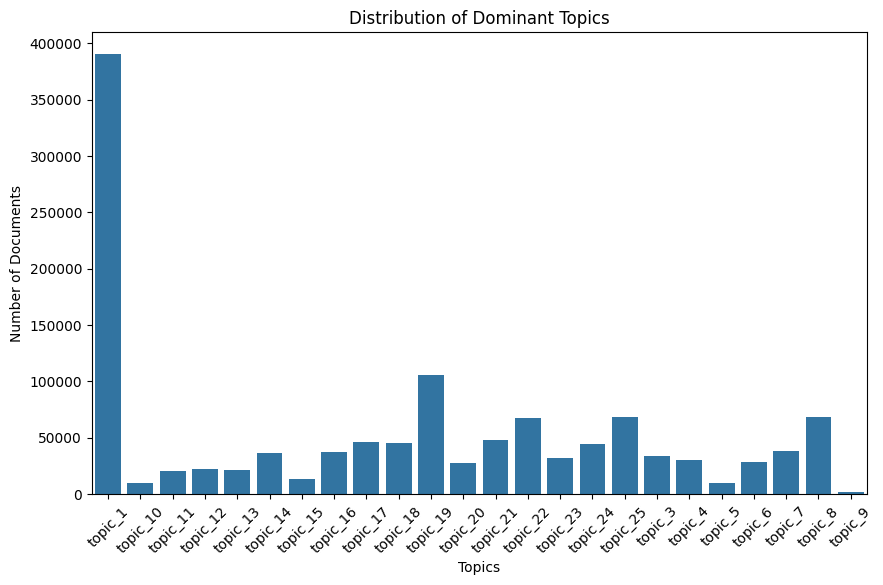

In [12]:
# Plot the distribution of dominant topics
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_distribution.index, y=topic_distribution.values)
plt.title("Distribution of Dominant Topics")
plt.xlabel("Topics")
plt.ylabel("Number of Documents")
plt.xticks(rotation=45)
plt.show()

Topic 1 might be strongly represented in the dataset or might be a 'catch all' topic. If the latter is true, this can be problematic and might be solved with adding more categories. However, it is likely a lot of the news is about general police interventions in murder cases. PLSI is not the best method to extract topics from text so maybe the distribution in LDA will make more sense.

### 2.5 Word frequencies

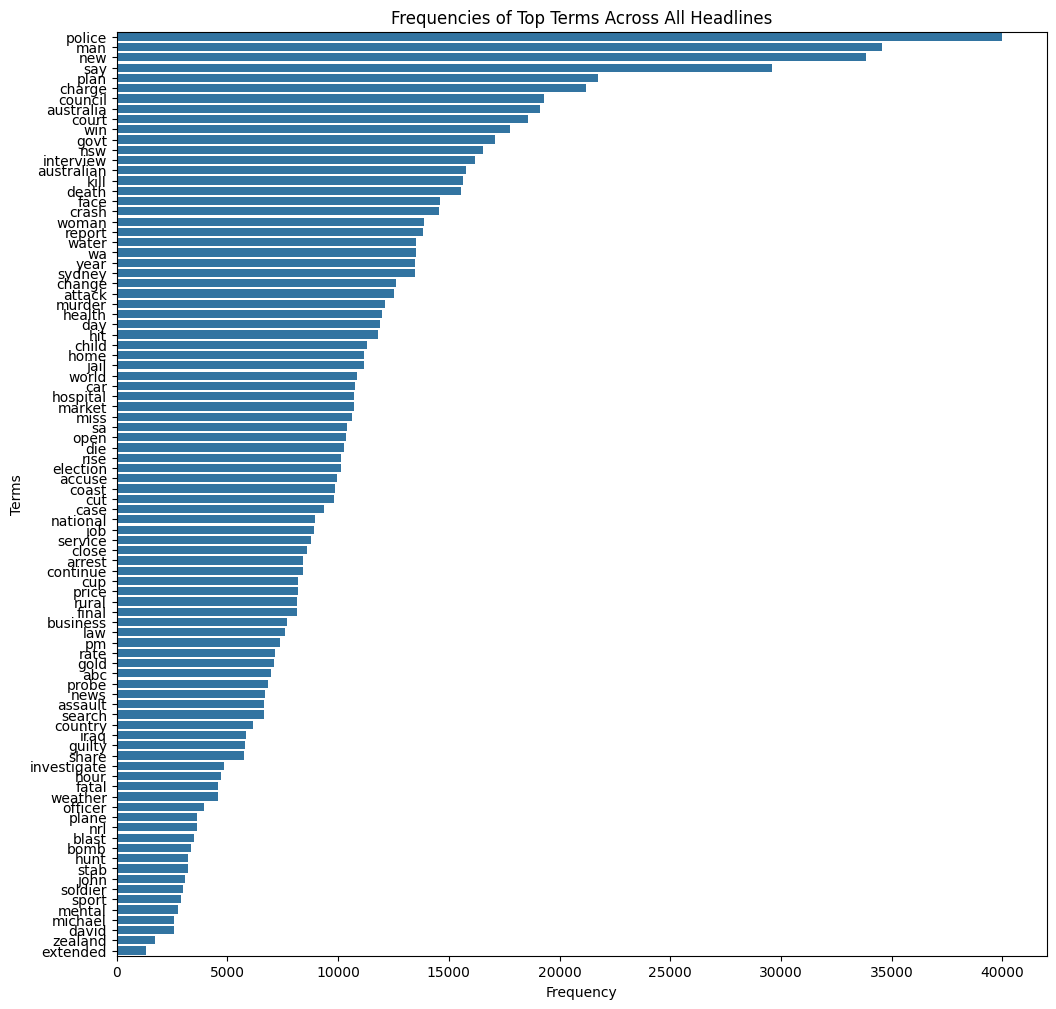

In [13]:
# Flatten the tokenized text into a single list
all_words = " ".join(body).split()  # Assuming 'body' is cleaned and space-separated
word_counts = Counter(all_words)

# Create a DataFrame to store term frequencies
term_freq_df = pd.DataFrame({
    "term": word_counts.keys(),
    "frequency": word_counts.values(),
})

# Filter the DataFrame to include only the top terms across all topics
all_top_terms = [term for terms_list in top_terms.values() for term in terms_list]
filtered_term_freq_df = term_freq_df[term_freq_df["term"].isin(all_top_terms)]

# Sort by frequency
filtered_term_freq_df = filtered_term_freq_df.sort_values(by="frequency", ascending=False)

# Display the term frequencies
#print(filtered_term_freq_df)

# Visualize the term frequencies
plt.figure(figsize=(12, 12))
sns.barplot(data=filtered_term_freq_df, x="frequency", y="term")
plt.title("Frequencies of Top Terms Across All Headlines")
plt.xlabel("Frequency")
plt.ylabel("Terms")
plt.show()

## 3 LDA

### 3.1 The most frequent words in each topic

We first apply LDA to extract topics from a document-term matrix and show the top words for each topic in a DataFrame

In [14]:
# we have already defined many processes beforehand (n_topics, bag_of_words, TFiDFVectorizer, etc.)

# Step 1: Apply Latent Dirichlet Allocation (LDA)
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(bag_of_words)

# Step 2: Display the topics and the top words for each topic
# Get the feature names (words)
terms = vectorizer.get_feature_names_out()

# Create a DataFrame to display the topic-term distribution
n_top_words = 10
topic_words = []
for topic_idx, topic in enumerate(lda.components_):
    topic_words.append([terms[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

# Create DataFrame for better visualization
topic_df = pd.DataFrame(topic_words, columns=[f"word_{i+1}" for i in range(n_top_words)])
topic_df.index = [f"Topic {i+1}" for i in range(n_topics)]

# Display the DataFrame
display(topic_df)

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10
Topic 1,interview,ashe,extended,uranium,real,welfare,mark,forestry,fraser,anniversary
Topic 2,water,bushfire,rain,blaze,farmer,drought,north,flood,cyclone,grower
Topic 3,kill,iraq,soldier,bomb,troop,blast,attack,afghan,iraqi,afghanistan
Topic 4,miss,search,close,pm,fisherman,inquest,broken,police,leadership,man
Topic 5,health,law,mental,right,anti,transport,public,plan,group,forest
Topic 6,emergency,waste,detention,dump,approval,centre,reserve,council,plan,hospital
Topic 7,sport,uni,rail,line,forum,seat,election,solar,candidate,abc
Topic 8,gas,whale,leak,stage,tour,phone,asia,course,mobile,shopping
Topic 9,afl,violence,nrl,domestic,update,final,player,grand,george,wide
Topic 10,cancer,asylum,seeker,list,patient,nurse,iran,rudd,memorial,treatment


Conclusion: The topics are more distinct than in the PLSI analysis which is as expected. The number of topics could be increased as currently the theme of some topics are unlear / some topics seem to combine multiple themes.

### 3.2  Topic distribution

Document count per dominant topic:
dominant_topic
0      37756
1      76814
2      71925
3      40957
4      58038
5      45683
6      41450
7      40862
8      47802
9      44282
10     56115
11     37815
12     69757
13     50430
14     38895
15     48461
16    110317
17     39444
18     37087
19     39053
20     46980
21     41425
22     44367
23     39506
24     38946
Name: count, dtype: int64


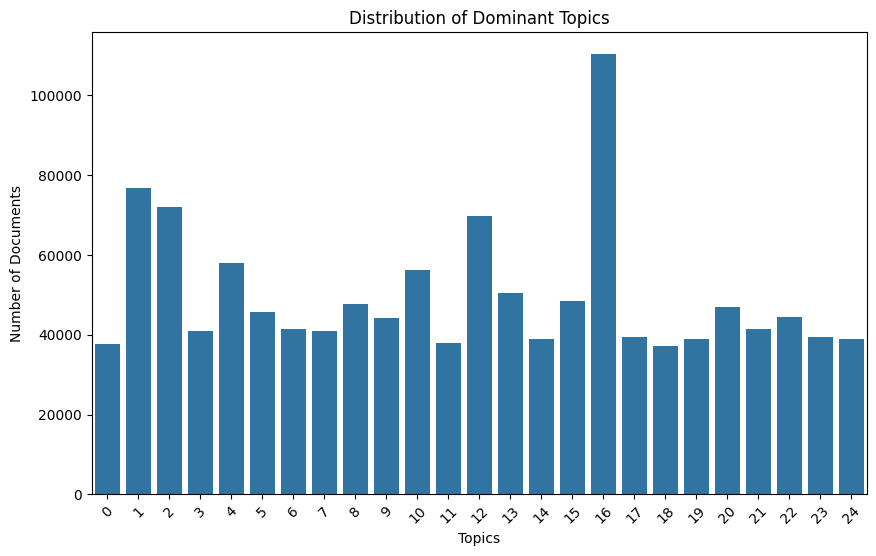

In [15]:
# Step 3: Get topic distribution for each document
# The `transform` method gives the topic distribution for each document
topic_distribution_matrix = lda.transform(bag_of_words)

# Step 4: Add a column for the dominant topic in each document
# The topic with the highest probability for each document is the "dominant" topic
dominant_topic = topic_distribution_matrix.argmax(axis=1)

# Create a DataFrame with the topic distributions and the dominant topic for each document
tedf = pd.DataFrame(topic_distribution_matrix, columns=[f"topic_{i+1}" for i in range(n_topics)])
tedf['dominant_topic'] = dominant_topic

# Step 5: Count the number of documents assigned to each dominant topic
topic_distribution = tedf['dominant_topic'].value_counts().sort_index()

# Step 6: Display the topic distribution
print("Document count per dominant topic:")
print(topic_distribution)

# Step 7: Plot the distribution of dominant topics
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_distribution.index, y=topic_distribution.values)
plt.title("Distribution of Dominant Topics")
plt.xlabel("Topics")
plt.ylabel("Number of Documents")
plt.xticks(rotation=45)
plt.show()

In [16]:
tedf.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,dominant_topic
0,0.012557,0.416941,0.012557,0.012557,0.012557,0.012557,0.012557,0.294238,0.012557,0.012557,...,0.012557,0.012557,0.012557,0.012557,0.012557,0.012557,0.012557,0.012557,0.012557,1
1,0.013455,0.013455,0.013455,0.013455,0.013455,0.013455,0.013455,0.013455,0.013455,0.013455,...,0.216186,0.013455,0.013455,0.013455,0.013455,0.013455,0.013455,0.242060,0.013455,15
2,0.014644,0.014644,0.014644,0.014644,0.014644,0.014644,0.014644,0.014644,0.014644,0.014644,...,0.014644,0.014644,0.014644,0.014644,0.014644,0.014644,0.014644,0.014644,0.014644,12
3,0.010988,0.010988,0.736287,0.010988,0.010988,0.010988,0.010988,0.010988,0.010988,0.010988,...,0.010988,0.010988,0.010988,0.010988,0.010988,0.010988,0.010988,0.010988,0.010988,2
4,0.011697,0.011697,0.011697,0.011697,0.011697,0.011697,0.011697,0.011697,0.011697,0.011697,...,0.011697,0.011697,0.011697,0.011697,0.011697,0.011697,0.011697,0.011697,0.011697,11


Compared with topic distribution from LSA, the topics are relatively more evenly distributed in LDA.

### 3.3 Visualize the most frequent words with word cloud

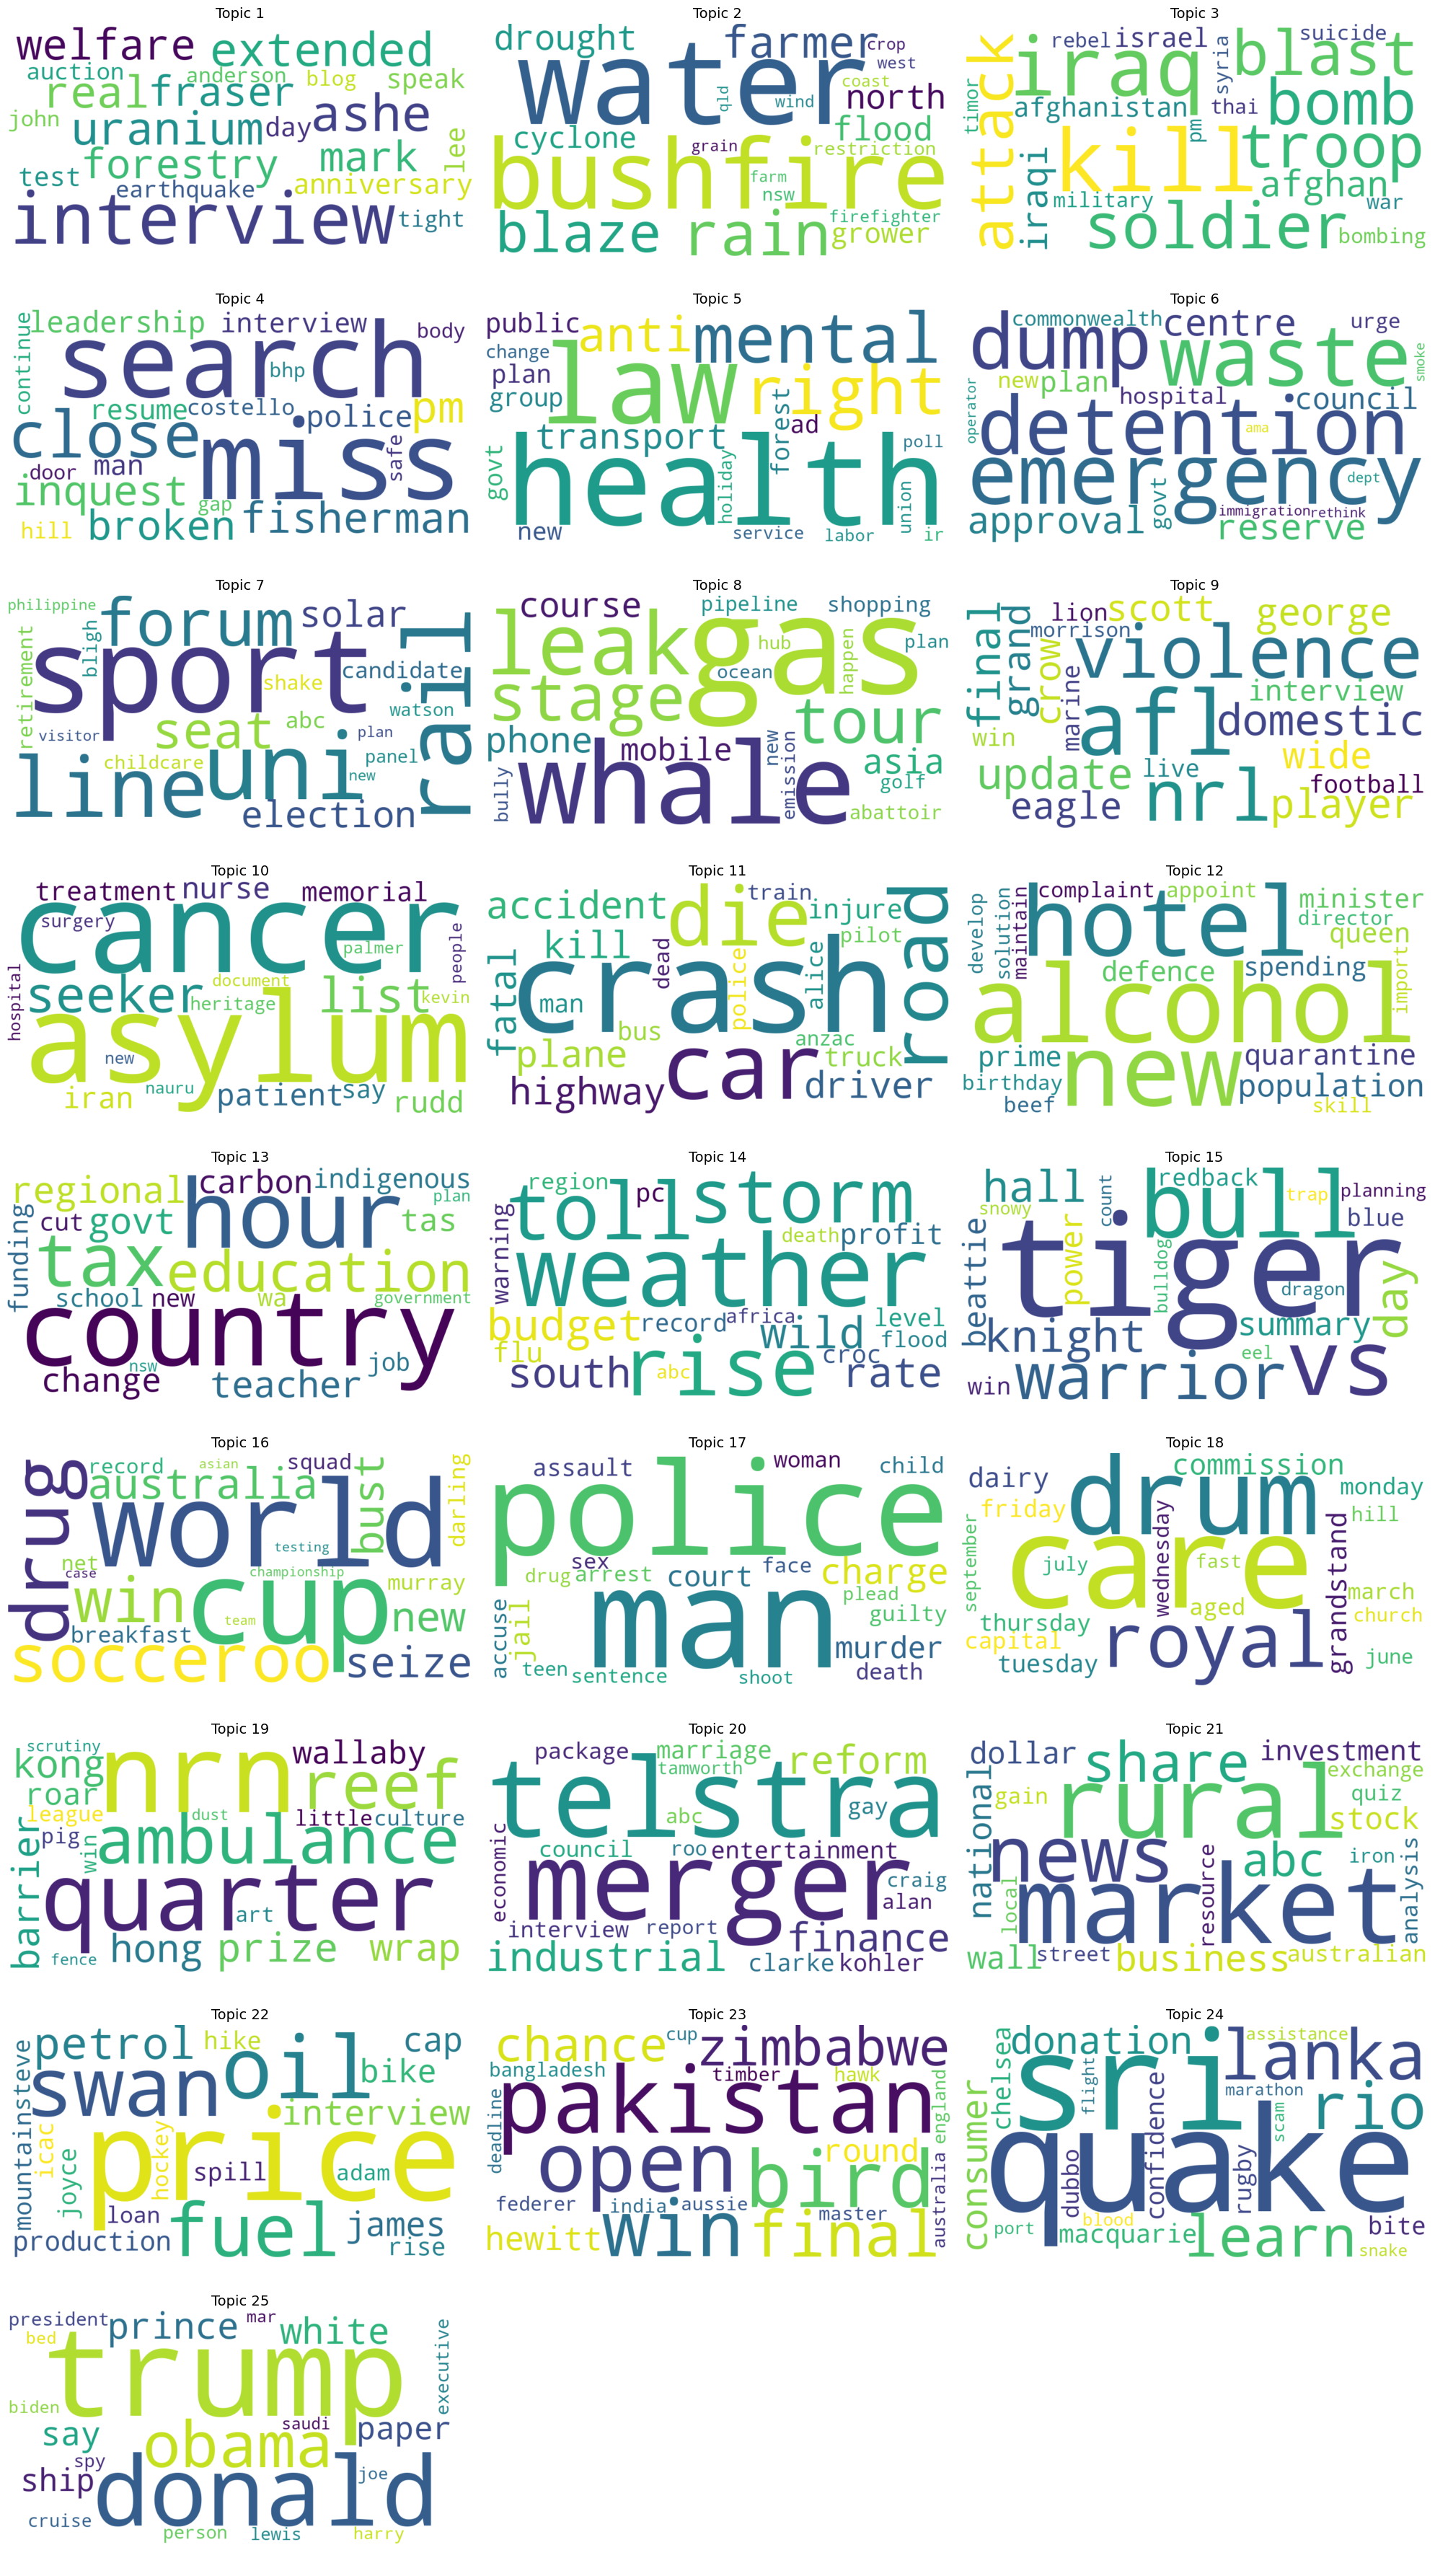

In [17]:
# Step 1: Extract topic-term distributions
# Normalize lda.components_ to get topic probabilities
topic_term_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Step 2: Create a WordCloud for each topic
def create_wordcloud(topic_idx, topic_distribution, terms, max_words=25):
    # Create a dictionary of words and their corresponding weights
    word_freq = {terms[i]: topic_distribution[i] for i in range(len(terms))}
    
    # Sort by frequency and take the top `max_words`
    word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:max_words])
    
    # Generate the WordCloud
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(word_freq)
    return wordcloud

# Step 3: Plot word clouds for all topics in a grid layout
def plot_wordclouds_in_grid(topic_term_distributions, terms, max_words=25, cols=4):
    n_topics = len(topic_term_distributions)
    rows = (n_topics + cols - 1) // cols  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for topic_idx, topic_distribution in enumerate(topic_term_distributions):
        wordcloud = create_wordcloud(topic_idx, topic_distribution, terms, max_words)
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].set_title(f"Topic {topic_idx + 1}", fontsize=14)
        axes[topic_idx].axis("off")
    
    # Turn off axes for any extra subplots
    for i in range(len(topic_term_distributions), len(axes)):
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

# Apply functions
terms = vectorizer.get_feature_names_out()
plot_wordclouds_in_grid(topic_term_distributions, terms, max_words=20, cols=3)


### We give each of the topics a 'name'/title:
0. Interviews
1. Weather (disasters)
2. War (Iraq/Afghanistan)
3. Missing Persons and Police Investigations
4. (Mental) Health Policy
5. Environmental Management
6. Elections and Sports
7. Mixed
8. Sports & Violence
9. Healthcare and Asylum Seekers
10. Road and Air Accidents
11. Alcohol Policy
12. Education Policy
13. Weather and impact on economy
14. Sports Matches
15. World Cup and Drug Busts
16. Crime and Court Cases with Police Involvement
17. Unclear
18. Mixed
19. Mergers and Finance News
20. Markets and Business Updates
21. Oil and Fuel Costs and Effects on Production
22. International Sports Matches
23. Unclear
24. International Politics, Centered Around the USA

## 4 Evolution of topics

### 4.1 Topics trends

In this part, we use the topics derived from LDA analysis to see how these 25 topics evolve over time on a yearly basis using a line chart.

In [20]:
data = data.dropna()
data.head()

,headline_cleaned,publish_date_c
0,aba decide community broadcasting licence,2003-02-19
1,act fire witness must aware defamation,2003-02-19
2,g call infrastructure protection summit,2003-02-19
3,air nz staff aust strike pay rise,2003-02-19
4,air nz strike affect australian traveller,2003-02-19


In [21]:
data['publish_date_c'] = pd.to_datetime(data['publish_date_c'])
data['year'] = data['publish_date_c'].dt.year
data.head()

,headline_cleaned,publish_date_c,year
0,aba decide community broadcasting licence,2003-02-19,2003
1,act fire witness must aware defamation,2003-02-19,2003
2,g call infrastructure protection summit,2003-02-19,2003
3,air nz staff aust strike pay rise,2003-02-19,2003
4,air nz strike affect australian traveller,2003-02-19,2003


In [22]:
print(data['year'].min(), data['year'].max())

2003 2021


In [23]:
# Add date back to the data
tedf['year'] = data['year'].values

# Count occurrences of each dominant topic per year
topic_trend = tedf.groupby(["year", "dominant_topic"]).size().reset_index(name="count")

# Pivot to create columns for each topic
topic_trend_pivot = topic_trend.pivot(index="year", columns="dominant_topic", values="count").fillna(0)

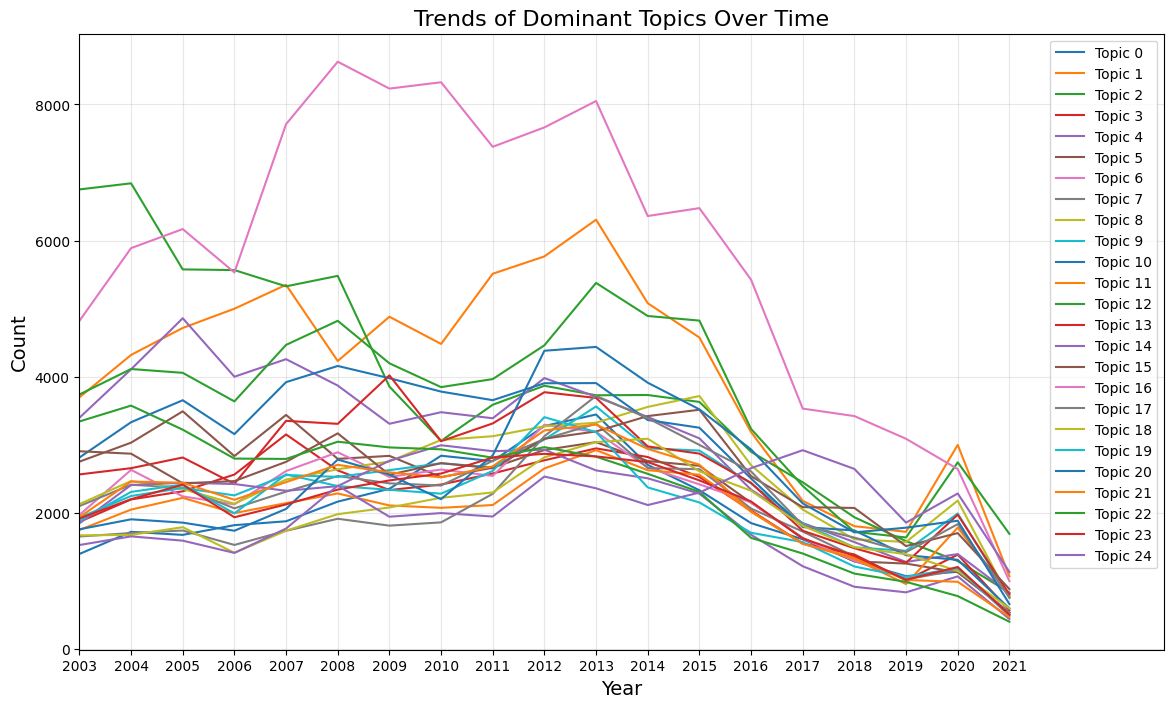

In [24]:
# Plot the trends
plt.figure(figsize=(14, 8))
for topic in topic_trend_pivot.columns:
    plt.plot(topic_trend_pivot.index, topic_trend_pivot[topic], label=f"Topic {topic}")

# Customize the plot
plt.title("Trends of Dominant Topics Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xlim(2003, 2024)
plt.xticks(ticks=np.arange(topic_trend_pivot.index.min(), topic_trend_pivot.index.max() + 1, 1), fontsize=10)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# Show the plot
plt.show()


Topic 16 seems to be the dominating topic for most of the years. We described the topic as 'Crime and Court Cases with Police Involvement'. It makes sense this topic is consistently near the top of most reported on.
Topic 2 was prominent in 2003 and 2004 but fell off afterwards This topic was named 'War (Iraq/Afghanistan)' so it makes sense the height of this topic was in the beginning of the 21st century. However, the topic of war remains relevant even in the next year with an increase starting in 2013. This denotes the war between Iraq and its allies and the Islamic State.
Weather disasters (Topic 1) also is a often-reported topic.

In [25]:
topic_trend

,year,dominant_topic,count
0,2003,0,1390
1,2003,1,3693
2,2003,2,6751
3,2003,3,1863
4,2003,4,3393
...,...,...,...
470,2021,20,654
471,2021,21,463
472,2021,22,394
473,2021,23,498


In [26]:
top_5_topics_per_year = (
    topic_trend.groupby("year")
    .apply(lambda x: x.nlargest(5, "count")["dominant_topic"].tolist())
    .reset_index(name="top_topics")
)

# Display the result
print(top_5_topics_per_year)

    year           top_topics
0   2003    [2, 16, 12, 1, 4]
1   2004    [2, 16, 1, 12, 4]
2   2005    [16, 2, 4, 1, 12]
3   2006    [2, 16, 1, 4, 12]
4   2007    [16, 1, 2, 12, 4]
5   2008   [16, 2, 12, 1, 10]
6   2009  [16, 1, 12, 13, 10]
7   2010   [16, 1, 12, 10, 4]
8   2011   [16, 1, 12, 10, 2]
9   2012   [16, 1, 12, 20, 4]
10  2013  [16, 1, 12, 20, 10]
11  2014   [16, 1, 12, 20, 2]
12  2015    [16, 12, 1, 8, 2]
13  2016   [16, 12, 1, 20, 2]
14  2017   [16, 24, 2, 12, 1]
15  2018   [16, 24, 15, 2, 1]
16  2019  [16, 24, 20, 1, 12]
17  2020   [1, 12, 16, 24, 8]
18  2021  [12, 24, 1, 16, 15]


C:\Users\kkasp\AppData\Local\Temp\ipykernel_7412\2962928173.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, "count")["dominant_topic"].tolist())


### 4.2 Dynamic topic modelling 

Instead of using topics derived from the overall dataset, we also applied LDA to each year separately to extract the top topics and their most frequent words for each year.

In [27]:
# Function to apply LDA to a given year
def apply_lda_to_year(year_data, n_topics=5):
    # Vectorize the text using CountVectorizer
    vectorizer = CountVectorizer(stop_words='english', min_df=2)  
    X = vectorizer.fit_transform(year_data['headline_cleaned'])
    
    # Apply LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    
    return lda, vectorizer

In [28]:
lda_results = {}

# Apply LDA for each year
for year in data['year'].unique():
    year_data = data[data['year'] == year]
    lda, vectorizer = apply_lda_to_year(year_data)
    lda_results[year] = (lda, vectorizer)

In [29]:
# Function to display the top words for each topic
def display_lda_topics(lda, vectorizer, n_words=10):
    terms = vectorizer.get_feature_names_out()
    topics = []
    
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [terms[i] for i in top_words_idx]
        topics.append(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    
    return topics

# Display top words for each year
for year, (lda, vectorizer) in lda_results.items():
    print(f"Year: {year}")
    topics = display_lda_topics(lda, vectorizer)
    for topic in topics:
        print(topic)


Year: 2003
Topic 1: man, charge, iraq, court, face, police, war, murder, drug, hospital
Topic 2: new, govt, plan, help, urge, group, welcome, child, centre, sar
Topic 3: win, test, rate, england, aussie, rise, south, port, high, world
Topic 4: police, kill, crash, attack, death, man, world, probe, cup, car
Topic 5: council, water, plan, govt, concern, boost, wa, consider, air, strike
Year: 2004
Topic 1: warn, hit, aussie, test, high, south, market, ban, deal, oil
Topic 2: win, iraq, kill, set, lead, open, die, crash, gold, final
Topic 3: council, plan, govt, new, boost, urge, health, fund, group, seek
Topic 4: police, man, charge, court, death, drug, jail, face, murder, kill
Topic 5: govt, new, change, report, continue, miss, labor, plan, pm, search
Year: 2005
Topic 1: kill, crash, tsunami, iraq, victim, world, road, die, cup, talk
Topic 2: police, man, charge, death, probe, drug, attack, warn, driver, arrest
Topic 3: govt, change, health, hospital, jail, new, say, child, ir, urge
Topi

When we look at the topics per year, we see some new topics being introduced. Most noteable, the COVID-19 topic which is a top word in both topic 2 and topic 5 in 2020 and a top word in topic 2 in 2021. The topic did also show up in some test versions of the full timeframe analysis together with tags such as SARS but this did not make it into the final 25 topics.